Created on Tue Nov  7 16:59:14 2023

@author: Santiago D'hers

Use:

- This script will train AI models to identify exploration using mouse and object position

Requirements:

- The position.csv files processed by 1-Manage_H5.py
- Labeled data for the position files (to train the model)

or

- Access to the file colabeled_data.csv, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

In [1]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
import random
import datetime

import joblib

# from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
desktop = 'C:/Users/dhers/Desktop'
STORM_folder = os.path.join(desktop, 'STORM/models')

colabels_file = os.path.join(STORM_folder, 'colabels.csv')
colabels = pd.read_csv(colabels_file)

bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']
objects = ['obj']

train_with_average = True # If False, it trains with all the labels separately
make_discrete = False # If False, labels are float (not 0 and 1)
save_data = True # if True, the data processed will be saved with today's date

use_saved_data = False # if True, we use the dataframe processed previously
if use_saved_data:
    saved_data = '' # Select the model date you want to rescue

# Get the start time
start_time = datetime.datetime.now()

In [3]:
def recenter(df, point, bodyparts):
    # Create a copy of the original dataframe
    df_copy = df.copy()
    bodypart_columns = []
    
    for bodypart in bodyparts:
        # Subtract point_x from columns ending in _x
        x_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_x')]
        df_copy[x_cols] = df_copy[x_cols].apply(lambda col: col - df_copy[f'{point}_x'])
        
        # Subtract point_y from columns ending in _y
        y_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_y')]
        df_copy[y_cols] = df_copy[y_cols].apply(lambda col: col - df_copy[f'{point}_y'])
        
        # Collect bodypart columns
        bodypart_columns.extend(x_cols)
        bodypart_columns.extend(y_cols)
        
    return df_copy[bodypart_columns]

In [4]:
def reshape(df):
    reshaped_df = []
    
    # Iterate over each row index in the DataFrame
    for i in range(len(df)):
        # Determine which indices to include for reshaping
        indices_to_include = [
            max(0, i - 6),  # i - 6, ensure it's not negative
            max(0, i - 3),  # i - 3, ensure it's not negative
            max(0, i - 1),  # i - 1, ensure it's not negative
            i,              # current index
            min(len(df) - 1, i + 1),  # i + 1, ensure it's not out of bounds
            min(len(df) - 1, i + 3),  # i + 3, ensure it's not out of bounds
            min(len(df) - 1, i + 6)   # i + 6, ensure it's not out of bounds
        ]
        
        # Append the rows using the calculated indices
        reshaped_df.append(df.iloc[indices_to_include])
    
    return reshaped_df

In [5]:
# The labels for left and right exploration are on the rest of the columns, we need to extract them
position = colabels.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy()
                         
lblr_A = colabels.filter(regex='Marian').copy()
lblr_B = colabels.filter(regex='Agus').copy()
lblr_C = colabels.filter(regex='Santi').copy()
lblr_D = colabels.filter(regex='Guille').copy()
lblr_E = colabels.filter(regex='Myself').copy()

labelers = [lblr_A, lblr_B, lblr_C, lblr_D, lblr_E]

In [6]:
if train_with_average:
    # Concatenate the dataframes along the columns axis (axis=1) and calculate the mean of each row
    combined_df = pd.concat(labelers, axis=1)
    avrg = pd.DataFrame(combined_df.mean(axis=1), columns=['mean'])

    # Apply median filter
    avrg['med_filt'] = signal.medfilt(avrg['mean'], kernel_size = 3)

    # Gaussian kernel
    gauss_kernel = signal.windows.gaussian(3, 0.6)
    gauss_kernel = gauss_kernel / sum(gauss_kernel)

    # Pad the median filtered data to mitigate edge effects
    pad_width = (len(gauss_kernel) - 1) // 2
    padded = np.pad(avrg['med_filt'], pad_width, mode='edge')

    # Apply convolution
    smooth = signal.convolve(padded, gauss_kernel, mode='valid')

    # Trim the padded edges to restore original length
    avrg['smooth'] = smooth[:len(avrg['mean'])]

    # Apply sigmoid function to keep values between 0 and 1
    avrg['labels'] = round(1 / (1 + np.exp(-12*(avrg['smooth']-0.5))), 2)

    ready_data = pd.concat([position, avrg['labels']], axis = 1)

else:
    # Join position with all the labels separately
    concatenated_position = pd.concat([position] * len(labelers), ignore_index=True)
    concatenated_labelers = pd.concat(labelers, ignore_index=True)
    ready_data = pd.concat([concatenated_position, concatenated_labelers], axis = 1)

In [7]:
def focus(df, column_to_filter = 'labels', distance = 25):

    # Extract the column of interest
    column_of_interest = df.loc[:, column_to_filter]

    print(f'Starting with {len(column_of_interest)} rows')

    # Find the indices of the non-zero rows in the column
    non_zero_indices = column_of_interest[column_of_interest != 0].index

    # Create a boolean mask to keep rows that are within 'distance' rows of a non-zero row
    mask = pd.Series(False, index=df.index)

    for idx in non_zero_indices:
        # Mark rows within 'distance' rows before and after the non-zero row
        lower_bound = max(0, idx - distance)
        upper_bound = min(len(df) - 1, idx + distance)
        mask[lower_bound:upper_bound + 1] = True

    # Filter the dataframe using the mask
    df_filtered = df[mask]

    # Optional: Reset index if you want a clean dataframe without gaps in the indices
    df_filtered.reset_index(drop=True, inplace=True)
    
    print(f"Reduced to {len(df_filtered)} rows. Number of exploration rows: {len(non_zero_indices)}")

    return df_filtered

In [8]:
ready_data_focus = focus(ready_data, distance = 50)

Starting with 167012 rows
Reduced to 63760 rows. Number of exploration rows: 17195


In [9]:
def prepare_training_data(df, obj = 'obj', bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body'], y_col = 'labels'):
    
    # Group the DataFrame by the values in the first column
    groups = df.groupby(df[f'{obj}_x'])
    
    # Split the DataFrame into multiple DataFrames and labels
    final_dataframes = {}
    wide_dataframes = {}
    
    for category, group in groups:

        recentered_data = recenter(group, obj, bodyparts)
        labels = group[f'{y_col}']

        final_dataframes[category] = {'position': recentered_data, 'labels': labels}

        reshaped_data = reshape(recentered_data)
        wide_dataframes[category] = {'position': reshaped_data, 'labels': labels}
        
    # Get a list of the keys (categories)
    keys = list(wide_dataframes.keys())
    
    # Shuffle the keys
    np.random.shuffle(keys)
    
    # Calculate the lengths for each part
    len_val = len(keys) * 15 // 100
    len_test = len(keys) * 15 // 100
    
    # Use slicing to divide the list
    val_keys = keys[:len_val]
    test_keys = keys[len_val:(len_val + len_test)]
    train_keys = keys[(len_val + len_test):]
    
    # Initialize empty lists to collect dataframes
    X_train_wide = []
    X_test_wide = []
    X_val_wide = []

    X_train = []
    X_test = []
    X_val = []

    y_train = []
    y_test = []
    y_val = []
    
    # first the simple data 
    for key in train_keys:
        X_train_wide.append(wide_dataframes[key]['position'])
        X_train.append(final_dataframes[key]['position'])
        y_train.append(final_dataframes[key]['labels'])
    for key in test_keys:
        X_test_wide.append(wide_dataframes[key]['position'])
        X_test.append(final_dataframes[key]['position'])
        y_test.append(final_dataframes[key]['labels'])
    for key in val_keys:
        X_val_wide.append(wide_dataframes[key]['position'])
        X_val.append(final_dataframes[key]['position'])
        y_val.append(final_dataframes[key]['labels'])
    
    X_train_wide = np.concatenate(X_train_wide, axis=0)
    X_test_wide = np.concatenate(X_test_wide, axis=0)
    X_val_wide = np.concatenate(X_val_wide, axis=0)

    X_train = pd.concat(X_train, ignore_index=True)
    X_test = pd.concat(X_test, ignore_index=True)
    X_val = pd.concat(X_val, ignore_index=True)
        
    y_train = pd.concat(y_train, ignore_index=True)
    y_test = pd.concat(y_test, ignore_index=True)
    y_val = pd.concat(y_val, ignore_index=True)
    
    return X_train_wide, X_train, y_train, X_test_wide, X_test, y_test, X_val_wide, X_val, y_val

In [10]:
if use_saved_data:
    # Load arrays
    with h5py.File(saved_data, 'r') as hf:
        X_test = hf['X_test'][:]
        y_test = hf['y_test'][:]
        X_val = hf['X_val'][:]
        y_val = hf['y_val'][:]
        X_train = hf['X_train'][:]
        y_train = hf['y_train'][:]
        X_test_wide = hf['X_test_wide'][:]
        X_val_wide = hf['X_val_wide'][:]
        X_train_wide = hf['X_train_wide'][:]
        
    print("Data is ready to train")

else:
    X_train_wide, X_train, y_train, X_test_wide, X_test, y_test, X_val_wide, X_val, y_val = prepare_training_data(ready_data_focus)
    
    # Print the sizes of each set
    print(f"Training set size: {len(X_train)} samples")
    print(f"Validation set size: {len(X_val)} samples")
    print(f"Testing set size: {len(X_test)} samples")
    print(f"Total samples: {len(X_train)+len(X_val)+len(X_test)}")

    if save_data:
        # Save arrays
        with h5py.File(os.path.join(STORM_folder, f'training_data/training_data_{start_time.date()}.h5'), 'w') as hf:
            hf.create_dataset('X_test', data=X_test)
            hf.create_dataset('y_test', data=y_test)
            hf.create_dataset('X_val', data=X_val)
            hf.create_dataset('y_val', data=y_val)
            hf.create_dataset('X_train', data=X_train)
            hf.create_dataset('y_train', data=y_train)
            hf.create_dataset('X_test_wide', data=X_test_wide)
            hf.create_dataset('X_val_wide', data=X_val_wide)
            hf.create_dataset('X_train_wide', data=X_train_wide)
            
            print(f'Saved data to training_data_{start_time.date()}.h5')

Training set size: 44344 samples
Validation set size: 9004 samples
Testing set size: 10412 samples
Total samples: 63760
Saved data to training_data_2024-10-22.h5


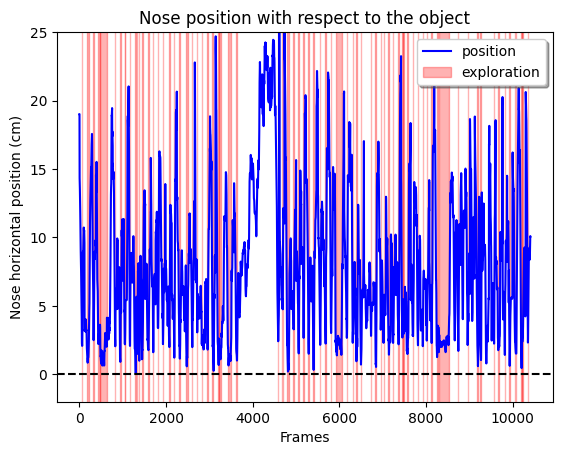

In [11]:
# Select data to plot
position = np.sqrt(X_test['nose_x']**2 + X_test['nose_y']**2).copy()
exploration = y_test.copy()

# Plotting position
plt.plot(position, label='position', color='blue')

# Shading exploration regions
plt.fill_between(range(len(exploration)), -30, 30, where = exploration > 0.5, label = 'exploration', color='red', alpha=0.3)

# Adding labels
plt.xlabel('Frames')
plt.ylabel('Nose horizontal position (cm)')
plt.legend(loc='upper right', fancybox=True, shadow=True, framealpha=1.0)
plt.title('Nose position with respect to the object')
plt.axhline(y=0, color='black', linestyle='--')

# Zoom in on some frames
# plt.xlim((1000, 2500))
plt.ylim((-2, 25))

plt.show()

Lets get some tools ready for model training:

- Early stopping
- Scheduled learning rate

In [12]:
# Set the number of neurons in each layer
param_0 = 128
param_H1 = 64
param_H2 = 32
param_H3 = 16

batch_size = 256 # Set the batch size
lr = 0.0002 # Set the initial learning rate
epochs = 80 # Set the training epochs
patience = 16 # Set the wait for the early stopping mechanism

In [13]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    mode='min',
    verbose=1,
)

# Define a learning rate schedule function
initial_lr = lr # Set the initial lr
def lr_schedule(epoch, lr): # Define a learning rate schedule function
    initial_lr = lr  # Initial learning rate
    decay_factor = 0.8  # Learning rate decay factor
    decay_epochs = 16    # Number of epochs after which to decay the learning rate

    # Calculate the new learning rate
    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))

    return lr

# Define the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [14]:
def plot_history(model, model_name):
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(model.history['loss'], label='Training loss')
    plt.plot(model.history['val_loss'], label='Validation loss')
    plt.plot(model.history['accuracy'], label='Training accuracy')
    plt.plot(model.history['val_accuracy'], label='Validation accuracy')
    
    plt.title(f'Training of model {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('%')
    plt.legend()
    plt.show()

In [15]:
def evaluate(X, y, model):
    
    # Evaluate the model on the testing set
    y_pred = model.predict(X)
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
    
    if isinstance(y, tf.Tensor):
        y = y.numpy()
    y_binary = (y > 0.5).astype(int) # Convert average labels to binary labels
    
    accuracy = accuracy_score(y_binary, y_pred_binary)
    precision = precision_score(y_binary, y_pred_binary, average = 'weighted')
    recall = recall_score(y_binary, y_pred_binary, average = 'weighted')
    f1 = f1_score(y_binary, y_pred_binary, average = 'weighted')
    
    print(classification_report(y_binary, y_pred_binary))
    
    return accuracy, precision, recall, f1

def evaluate_continuous(X, y, model):
    # Ensure X and y are on the same device
    if isinstance(X, tf.Tensor):
        if '/GPU:' in X.device:
            y = tf.convert_to_tensor(y)
            y = tf.identity(y)

    # Evaluate the model on the testing set
    y_pred = model.predict(X)

    # Convert y and y_pred to numpy arrays if they are tensors
    if isinstance(y_pred, tf.Tensor):
        y_pred = y_pred.numpy()
    
    if isinstance(y, tf.Tensor):
        y = y.numpy()
    
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return mse, mae, r2

Now we train the first model

In [16]:
# Build a simple neural network
model_simple = tf.keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(param_0, activation='relu'),
    Dropout(0.2),
    Dense(param_H1, activation='relu'),
    Dropout(0.2),
    Dense(param_H2, activation='relu'),
    Dropout(0.2),
    Dense(param_H3, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                     loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1664      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                5

In [18]:
# Train the model
history_simple = model_simple.fit(X_train, y_train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=(X_val, y_val),
                                  callbacks=[early_stopping, lr_scheduler])

Epoch 1/80
174/174 [==============================] - 1s 5ms/step - loss: 0.4868 - accuracy: 0.6489 - val_loss: 0.2811 - val_accuracy: 0.7671 - lr: 2.0000e-04
Epoch 2/80
174/174 [==============================] - 1s 4ms/step - loss: 0.3348 - accuracy: 0.7350 - val_loss: 0.2422 - val_accuracy: 0.7671 - lr: 2.0000e-04
Epoch 3/80
174/174 [==============================] - 1s 4ms/step - loss: 0.2828 - accuracy: 0.7413 - val_loss: 0.1930 - val_accuracy: 0.7690 - lr: 2.0000e-04
Epoch 4/80
174/174 [==============================] - 1s 4ms/step - loss: 0.2410 - accuracy: 0.7672 - val_loss: 0.1652 - val_accuracy: 0.8145 - lr: 2.0000e-04
Epoch 5/80
174/174 [==============================] - 1s 4ms/step - loss: 0.2091 - accuracy: 0.7942 - val_loss: 0.1396 - val_accuracy: 0.8233 - lr: 2.0000e-04
Epoch 6/80
174/174 [==============================] - 1s 4ms/step - loss: 0.1901 - accuracy: 0.8036 - val_loss: 0.1325 - val_accuracy: 0.8245 - lr: 2.0000e-04
Epoch 7/80
174/174 [==========================

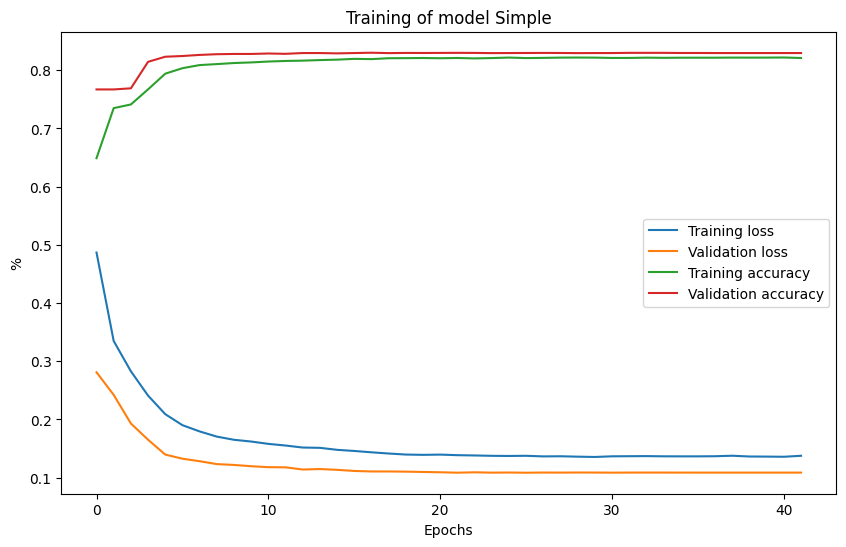

In [19]:
# Plot the training and validation loss
plot_history(history_simple, "Simple")

In [20]:
# Calculate accuracy and precision of the model
accuracy_simple, precision_simple, recall_simple, f1_simple = evaluate(X_test, y_test, model_simple)
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")

mse_simple, mae_simple, r2_simple = evaluate_continuous(X_test, y_test, model_simple)
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")

326/326 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      8682
           1       0.82      0.83      0.82      1730

    accuracy                           0.94     10412
   macro avg       0.89      0.90      0.89     10412
weighted avg       0.94      0.94      0.94     10412

Accuracy = 0.9406, Precision = 0.9409, Recall = 0.9406, F1 Score = 0.9408 -> simple
326/326 [==============================] - 0s 1ms/step
MSE = 0.0298, MAE = 0.0718, R-squared = 0.7651 -> simple


In [21]:
# Save the model
model_simple.save(os.path.join(STORM_folder, f'simple/model_simple_{start_time.date()}.keras'))

Lets move onto training a Recursive Network (that can see sequences)

In [22]:
frames = 7

# Define the LSTM model
model_wide = tf.keras.Sequential([
    Input(shape=(frames, X_train_wide.shape[2])),
    LSTM(param_0, return_sequences=True),
    Dropout(0.2),
    LSTM(param_H1, return_sequences=True),
    Dropout(0.2),
    LSTM(param_H2, return_sequences=True),
    Dropout(0.2),
    LSTM(param_H3),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_wide.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                     loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
model_wide.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            72192     
                                                                 
 dropout_4 (Dropout)         (None, 7, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             49408     
                                                                 
 dropout_5 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 32)             12416     
                                                                 
 dropout_6 (Dropout)         (None, 7, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 16)               

In [24]:
# Train the model
history_wide = model_wide.fit(X_train_wide, y_train,
                              epochs = epochs,
                              batch_size = batch_size,
                              validation_data=(X_val_wide, y_val),
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/80
174/174 [==============================] - 7s 20ms/step - loss: 0.3564 - accuracy: 0.7577 - val_loss: 0.1847 - val_accuracy: 0.8174 - lr: 2.0000e-04
Epoch 2/80
174/174 [==============================] - 3s 16ms/step - loss: 0.1935 - accuracy: 0.8100 - val_loss: 0.1657 - val_accuracy: 0.8193 - lr: 2.0000e-04
Epoch 3/80
174/174 [==============================] - 3s 16ms/step - loss: 0.1708 - accuracy: 0.8145 - val_loss: 0.1428 - val_accuracy: 0.8236 - lr: 2.0000e-04
Epoch 4/80
174/174 [==============================] - 3s 16ms/step - loss: 0.1506 - accuracy: 0.8191 - val_loss: 0.1243 - val_accuracy: 0.8280 - lr: 2.0000e-04
Epoch 5/80
174/174 [==============================] - 3s 16ms/step - loss: 0.1364 - accuracy: 0.8219 - val_loss: 0.1208 - val_accuracy: 0.8276 - lr: 2.0000e-04
Epoch 6/80
174/174 [==============================] - 3s 16ms/step - loss: 0.1274 - accuracy: 0.8241 - val_loss: 0.1140 - val_accuracy: 0.8286 - lr: 2.0000e-04
Epoch 7/80
174/174 [====================

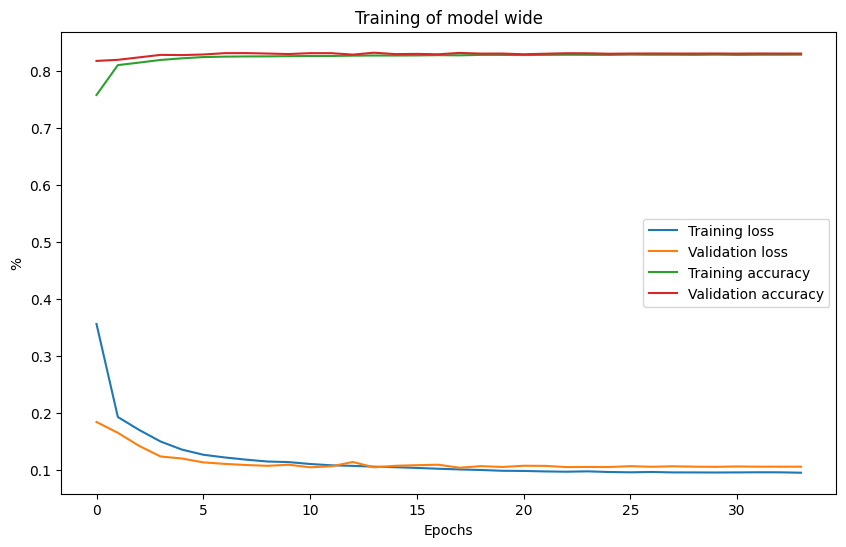

In [25]:
# Plot the training and validation loss
plot_history(history_wide, "wide")

In [26]:
# Calculate accuracy and precision of the model
accuracy_wide, precision_wide, recall_wide, f1_wide = evaluate(X_test_wide, y_test, model_wide)
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")

mse_wide, mae_wide, r2_wide = evaluate_continuous(X_test_wide, y_test, model_wide)
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")

326/326 [==============================] - 3s 6ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8682
           1       0.83      0.88      0.85      1730

    accuracy                           0.95     10412
   macro avg       0.90      0.92      0.91     10412
weighted avg       0.95      0.95      0.95     10412

Accuracy = 0.9491, Precision = 0.9507, Recall = 0.9491, F1 Score = 0.9497 -> wide
326/326 [==============================] - 2s 6ms/step
MSE = 0.0292, MAE = 0.0627, R-squared = 0.7700 -> wide


In [27]:
# Save the model
model_wide.save(os.path.join(STORM_folder, f'wide/model_wide_{start_time.date()}.keras'))

Lets also train a Random Forest model

In [28]:
# We train a RF model with the same data
if not make_discrete:
    y_train = (y_train > 0.5).astype(int)

# Create the Random Forest model (and set the number of estimators (decision trees))
RF_model = RandomForestClassifier(n_estimators = 24, max_depth = 12)

# Train the MultiOutputClassifier with your data
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=24)

In [29]:
# Calculate accuracy and precision of the model
accuracy_RF, precision_RF, recall_RF, f1_RF = evaluate(X_test, y_test, RF_model)
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

mse_RF, mae_RF, r2_RF = evaluate_continuous(X_test, y_test, RF_model)
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      8682
           1       0.81      0.85      0.83      1730

    accuracy                           0.94     10412
   macro avg       0.89      0.91      0.90     10412
weighted avg       0.94      0.94      0.94     10412

Accuracy = 0.9417, Precision = 0.9433, Recall = 0.9417, F1 Score = 0.9424 -> RF
MSE = 0.0512, MAE = 0.0670, R-squared = 0.5971 -> RF


In [30]:
# Save the model
joblib.dump(RF_model, os.path.join(STORM_folder, f'RF/model_RF_{start_time.date()}.pkl'))

['C:/Users/dhers/Desktop\\STORM/models\\RF/model_RF_2024-10-22.pkl']

In [31]:
# Get the end time
end_time = datetime.datetime.now()

# Calculate elapsed time
elapsed_time = end_time - start_time

In [32]:
# Print the model results
print(f"Script execution time: {elapsed_time}).")

print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

Script execution time: 0:02:49.760663).
Evaluate model vs testing data
VS binary average
Accuracy = 0.9406, Precision = 0.9409, Recall = 0.9406, F1 Score = 0.9408 -> simple
Accuracy = 0.9491, Precision = 0.9507, Recall = 0.9491, F1 Score = 0.9497 -> wide
Accuracy = 0.9417, Precision = 0.9433, Recall = 0.9417, F1 Score = 0.9424 -> RF
VS continuous average
MSE = 0.0298, MAE = 0.0718, R-squared = 0.7651 -> simple
MSE = 0.0292, MAE = 0.0627, R-squared = 0.7700 -> wide
MSE = 0.0512, MAE = 0.0670, R-squared = 0.5971 -> RF


In [33]:
# Lets test the accuracy of a random and zero y_test

y_zeros = y_test - y_test

y_random = y_test.sample(frac=1).reset_index(drop=True)
y_random_binary = (y_random > 0.5).astype(int)

y_binary = (y_test > 0.5).astype(int)

In [34]:
# zeros
print(classification_report(y_binary, y_zeros))

accuracy_zeros = accuracy_score(y_binary, y_zeros)
precision_zeros = precision_score(y_binary, y_zeros, average = 'weighted')
recall_zeros = recall_score(y_binary, y_zeros, average = 'weighted')
f1_zeros = f1_score(y_binary, y_zeros, average = 'weighted')
print(f"Accuracy = {accuracy_zeros:.4f}, Precision = {precision_zeros:.4f}, Recall = {recall_zeros:.4f}, F1 Score = {f1_zeros:.4f} -> zeros")

mse_zeros = mean_squared_error(y_test, y_zeros)
mae_zeros = mean_absolute_error(y_test, y_zeros)
r2_zeros = r2_score(y_test, y_zeros)
print(f"MSE = {mse_zeros:.4f}, MAE = {mae_zeros:.4f}, R-squared = {r2_zeros:.4f} -> zeros")

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      8682
           1       0.00      0.00      0.00      1730

    accuracy                           0.83     10412
   macro avg       0.42      0.50      0.45     10412
weighted avg       0.70      0.83      0.76     10412

Accuracy = 0.8338, Precision = 0.6953, Recall = 0.8338, F1 Score = 0.7583 -> zeros
MSE = 0.1568, MAE = 0.1727, R-squared = -0.2348 -> zeros


c:\Users\dhers\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dhers\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dhers\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dhers\anaconda3\env

In [35]:
# random
print(classification_report(y_binary, y_random_binary))

accuracy_random = accuracy_score(y_binary, y_random_binary)
precision_random = precision_score(y_binary, y_random_binary, average = 'weighted')
recall_random = recall_score(y_binary, y_random_binary, average = 'weighted')
f1_random = f1_score(y_binary, y_random_binary, average = 'weighted')
print(f"Accuracy = {accuracy_random:.4f}, Precision = {precision_random:.4f}, Recall = {recall_random:.4f}, F1 Score = {f1_random:.4f} -> random")

mse_random = mean_squared_error(y_test, y_random)
mae_random = mean_absolute_error(y_test, y_random)
r2_random = r2_score(y_test, y_random)
print(f"MSE = {mse_random:.4f}, MAE = {mae_random:.4f}, R-squared = {r2_random:.4f} -> random")

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      8682
           1       0.16      0.16      0.16      1730

    accuracy                           0.72     10412
   macro avg       0.50      0.50      0.50     10412
weighted avg       0.72      0.72      0.72     10412

Accuracy = 0.7221, Precision = 0.7221, Recall = 0.7221, F1 Score = 0.7221 -> random
MSE = 0.2547, MAE = 0.2840, R-squared = -1.0055 -> random


In [36]:
print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")
print(f"Accuracy = {accuracy_zeros:.4f}, Precision = {precision_zeros:.4f}, Recall = {recall_zeros:.4f}, F1 Score = {f1_zeros:.4f} -> zeros")
print(f"Accuracy = {accuracy_random:.4f}, Precision = {precision_random:.4f}, Recall = {recall_random:.4f}, F1 Score = {f1_random:.4f} -> random")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")
print(f"MSE = {mse_zeros:.4f}, MAE = {mae_zeros:.4f}, R-squared = {r2_zeros:.4f} -> zeros")
print(f"MSE = {mse_random:.4f}, MAE = {mae_random:.4f}, R-squared = {r2_random:.4f} -> random")

Evaluate model vs testing data
VS binary average
Accuracy = 0.9406, Precision = 0.9409, Recall = 0.9406, F1 Score = 0.9408 -> simple
Accuracy = 0.9491, Precision = 0.9507, Recall = 0.9491, F1 Score = 0.9497 -> wide
Accuracy = 0.9417, Precision = 0.9433, Recall = 0.9417, F1 Score = 0.9424 -> RF
Accuracy = 0.8338, Precision = 0.6953, Recall = 0.8338, F1 Score = 0.7583 -> zeros
Accuracy = 0.7221, Precision = 0.7221, Recall = 0.7221, F1 Score = 0.7221 -> random
VS continuous average
MSE = 0.0298, MAE = 0.0718, R-squared = 0.7651 -> simple
MSE = 0.0292, MAE = 0.0627, R-squared = 0.7700 -> wide
MSE = 0.0512, MAE = 0.0670, R-squared = 0.5971 -> RF
MSE = 0.1568, MAE = 0.1727, R-squared = -0.2348 -> zeros
MSE = 0.2547, MAE = 0.2840, R-squared = -1.0055 -> random
